#Grouping Strategy

In [1]:
import pytz
import os


DEFAULT_TZ = pytz.FixedOffset(540)  # GMT+09:00; Asia/Seoul

PATH_DATA = 'data/D'
PATH_ESM = os.path.join(PATH_DATA, 'EsmResponse.csv')
PATH_PARTICIPANT = os.path.join(PATH_DATA, 'UserInfo.csv')
PATH_SENSOR = os.path.join(PATH_DATA, 'Sensor')

PATH_INTERMEDIATE = os.path.join('data/intermediate')

DATA_TYPES = {
    'Acceleration': 'ACC',
    'AmbientLight': 'AML',
    'Calorie': 'CAL',
    'Distance': 'DST',
    'EDA': 'EDA',
    'HR': 'HRT',
    'RRI': 'RRI',
    'SkinTemperature': 'SKT',
    'StepCount': 'STP',
    'UltraViolet': 'ULV',
    'ActivityEvent': 'ACE',
    'ActivityTransition': 'ACT',
    'AppUsageEvent': 'APP',
    'BatteryEvent': 'BAT',
    'CallEvent': 'CAE',
    'Connectivity': 'CON',
    'DataTraffic': 'DAT',
    'InstalledApp': 'INS',
    'Location': 'LOC',
    'MediaEvent': 'MED',
    'MessageEvent': 'MSG',
    'WiFi': 'WIF',
    'ScreenEvent': 'SCR',
    'RingerModeEvent': 'RNG',
    'ChargeEvent': 'CHG',
    'PowerSaveEvent': 'PWS',
    'OnOffEvent': 'ONF'
}

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import cloudpickle
import ray
from datetime import datetime
from contextlib import contextmanager
import warnings
import time


def load(path: str):
    with open(path, mode='rb') as f:
        return cloudpickle.load(f)

    
def dump(obj, path: str):
    with open(path, mode='wb') as f:
        cloudpickle.dump(obj, f)
        
    
def log(msg: any):
    print('[{}] {}'.format(datetime.now().strftime('%y-%m-%d %H:%M:%S'), msg))


def summary(x):
    x = np.asarray(x)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        n = len(x)
        # Here, uppercase np.dtype.kind corresponds to non-numeric data.
        # Also, we view the boolean data as dichotomous categorical data.
        if x.dtype.kind.isupper() or x.dtype.kind == 'b': 
            cnt = pd.Series(x).value_counts(dropna=False)
            card = len(cnt)
            cnt = cnt[:20]                
            cnt_str = ', '.join([f'{u}:{c}' for u, c in zip(cnt.index, cnt)])
            if card > 30:
                cnt_str = f'{cnt_str}, ...'
            return {
                'n': n,
                'cardinality': card,
                'value_count': cnt_str
            }
        else: 
            x_nan = x[np.isnan(x)]
            x_norm = x[~np.isnan(x)]
            
            tot = np.sum(x_norm)
            m = np.mean(x_norm)
            me = np.median(x_norm)
            s = np.std(x_norm, ddof=1)
            l, u = np.min(x_norm), np.max(x)
            conf_l, conf_u = st.t.interval(0.95, len(x_norm) - 1, loc=m, scale=st.sem(x_norm))
            n_nan = len(x_nan)
            
            return {
                'n': n,
                'sum': tot,
                'mean': m,
                'SD': s,
                'med': me,
                'range': (l, u),
                'conf.': (conf_l, conf_u),
                'nan_count': n_nan
            }


@contextmanager
def on_ray(*args, **kwargs):
    try:
        if ray.is_initialized():
            ray.shutdown()
        ray.init(*args, **kwargs)
        yield None
    finally:
        ray.shutdown()

transform = {
    'GAME': 'ENTER',
    'GAME_TRIVIA': 'ENTER',
    'GAME_CASINO': 'ENTER',
    'GAME-ACTION': 'ENTER',
    'GAME_SPORTS': 'ENTER',
    'GAME_PUZZLE': 'ENTER',
    'GAME_SIMULATION': 'ENTER',
    'GAME_STRATEGY': 'ENTER',
    'GAME_ROLE_PLAYING': 'ENTER',
    'GAME_ACTION': 'ENTER',
    'GAME_ARCADE': 'ENTER',
    'GAME_RACING': 'ENTER',
    'GAME_CASUAL': 'ENTER',
    'GAME_MUSIC': 'ENTER',
    'GAME_CARD': 'ENTER',
    'GAME_ADVENTURE': 'ENTER',
    'GAME_BOARD': 'ENTER',
    'GAME_EDUCATIONAL': 'ENTER',
    'GAME_RACING': 'ENTER',
    'PHOTOGRAPHY': 'ENTER',
    'ENTERTAINMENT': 'ENTER',
    'SPORTS': 'ENTER',
    'MUSIC_AND_AUDIO': 'ENTER',
    'COMICS': 'ENTER',
    'VIDEO_PLAYERS_AND_EDITORS': 'ENTER',
    'VIDEO_PLAYERS': 'ENTER',
    'ART_AND_DESIGN': 'ENTER',
    'TRAVEL_AND_LOCAL': 'INFO',
    'FOOD_AND_DRINK': 'INFO',
    'NEWS_AND_MAGAZINES': 'INFO',
    'MAPS_AND_NAVIGATION': 'INFO',
    'WEATHER': 'INFO',
    'HOUSE_AND_HOME': 'INFO',
    'BOOKS_AND_REFERENCE': 'INFO',
    'SHOPPING': 'INFO',
    'LIBRARIES_AND_DEMO': 'INFO',
    'BEAUTY': 'INFO',
    'AUTO_AND_VEHICLES': 'INFO',
    'LIFESTYLE': 'INFO',
    'PERSONALIZATION': 'SYSTEM',
    'TOOLS': 'SYSTEM',
    'COMMUNICATION': 'SOCIAL',
    'SOCIAL': 'SOCIAL',
    'DATING': 'SOCIAL',
    'PARENTING':'SOCIAL',
    'FINANCE': 'WORK',
    'BUSINESS': 'WORK',
    'PRODUCTIVITY': 'WORK',
    'EDUCATION': 'WORK',
    'HEALTH_AND_FITNESS': 'HEALTH',
    'MEDICAL': 'HEALTH',
    'SYSTEM': 'SYSTEM',
    'MISC': 'SYSTEM', # ABC logger
     None: 'UNKNOWN',
    'UNKNOWN':'UNKNOWN'
}

In [3]:
LABELS_PROC = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'LABELS_PROC.csv'), index_col=['pcode','timestamp'],parse_dates=True)

In [4]:
_df =LABELS_PROC
_df.reset_index(level='timestamp', inplace=True)
print('First timestamp:', _df['timestamp'].min())
print('Last timestamp:', _df['timestamp'].max())

First timestamp: 2019-04-30 10:03:28+09:00
Last timestamp: 2019-05-22 22:02:03+09:00


In [5]:
_df.head()

,timestamp,responseTime,scheduledTime,valence,arousal,attention,stress,duration,disturbance,change,valence_dyn,arousal_dyn,stress_dyn,disturbance_dyn,valence_fixed,arousal_fixed,stress_fixed,disturbance_fixed
pcode,,,,,,,,,,,,,,,,,,
P01,2019-05-08 10:29:46+09:00,1557278986000,1.557279e+12,-3,3,3,3,5.0,-1,-3,0,1,1,0,0,1,1,0
P01,2019-05-08 11:16:12+09:00,1557281772000,1.557282e+12,-3,-2,2,2,15.0,3,-2,0,0,1,1,0,0,1,1
P01,2019-05-08 15:58:22+09:00,1557298702000,1.557299e+12,3,3,3,-3,20.0,2,0,1,1,0,1,1,1,0,1
P01,2019-05-08 16:41:51+09:00,1557301311000,1.557301e+12,3,3,3,-3,30.0,1,2,1,1,0,1,1,1,0,1
P01,2019-05-08 17:27:42+09:00,1557304062000,1.557304e+12,3,3,3,-3,20.0,2,2,1,1,0,1,1,1,0,1


In [6]:
time_ranges = _df.groupby('pcode')['timestamp'].agg(['min', 'max'])
print(time_ranges)

                            min                       max
pcode                                                    
P01   2019-05-08 10:29:46+09:00 2019-05-14 21:12:31+09:00
P02   2019-05-08 10:52:29+09:00 2019-05-14 21:13:14+09:00
P03   2019-05-08 11:13:13+09:00 2019-05-14 20:23:23+09:00
P05   2019-05-08 10:40:49+09:00 2019-05-14 21:59:16+09:00
P06   2019-05-08 10:32:09+09:00 2019-05-14 21:56:51+09:00
P08   2019-05-08 10:42:48+09:00 2019-05-14 21:12:32+09:00
P09   2019-05-08 13:44:51+09:00 2019-05-14 20:31:01+09:00
P10   2019-05-08 10:40:26+09:00 2019-05-14 15:13:12+09:00
P12   2019-05-09 14:18:30+09:00 2019-05-14 21:09:22+09:00
P13   2019-05-08 10:30:38+09:00 2019-05-14 21:51:35+09:00
P15   2019-05-08 12:09:34+09:00 2019-05-14 19:44:17+09:00
P19   2019-05-08 10:41:14+09:00 2019-05-14 22:01:12+09:00
P21   2019-05-08 15:49:36+09:00 2019-05-14 21:43:22+09:00
P23   2019-05-08 10:20:41+09:00 2019-05-14 18:13:07+09:00
P26   2019-05-08 10:11:53+09:00 2019-05-14 21:59:17+09:00
P28   2019-05-

In [7]:
l ='stress'
p = os.path.join(PATH_INTERMEDIATE,f'{l}.pkl')

X, y, groups, t, datetimes = load(p)


In [8]:
groups

array(['P01', 'P01', 'P01', ..., 'P80', 'P80', 'P80'], dtype='<U3')

In [9]:
PARTICIPANTS = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'PARTICIPANT_INFO.csv'),index_col = 'pcode')
PINFO = PARTICIPANTS.assign(
    BFI_OPN=lambda x: x['openness'],
    BFI_CON=lambda x: x['conscientiousness'],
    BFI_NEU=lambda x: x['neuroticism'],
    BFI_EXT=lambda x: x['extraversion'],
    BFI_AGR=lambda x: x['agreeableness'],
)[[
    'BFI_OPN', 'BFI_CON', 'BFI_NEU', 'BFI_EXT', 'BFI_AGR'
]]
PINFO = pd.get_dummies(PINFO, prefix_sep='=', dtype=bool)

In [10]:
PINFO

,BFI_OPN,BFI_CON,BFI_NEU,BFI_EXT,BFI_AGR
pcode,,,,,
P01,11,11,3,4,13
P02,14,5,12,14,5
P03,10,15,8,7,11
P04,12,11,8,6,11
P05,10,11,13,10,6
...,...,...,...,...,...
P76,8,8,12,6,8
P77,11,12,7,11,10
P78,12,11,9,12,10


In [11]:
list_pid = set(LABELS_PROC.index.get_level_values('pcode').values)
list_pid

{'P01',
 'P02',
 'P03',
 'P05',
 'P06',
 'P08',
 'P09',
 'P10',
 'P12',
 'P13',
 'P15',
 'P19',
 'P21',
 'P23',
 'P26',
 'P28',
 'P30',
 'P31',
 'P32',
 'P33',
 'P35',
 'P39',
 'P40',
 'P42',
 'P45',
 'P47',
 'P48',
 'P49',
 'P50',
 'P51',
 'P52',
 'P53',
 'P55',
 'P57',
 'P60',
 'P61',
 'P66',
 'P67',
 'P69',
 'P70',
 'P72',
 'P75',
 'P76',
 'P77',
 'P78',
 'P79',
 'P80'}

In [12]:
PINFO_valid = PINFO.loc[PINFO.index.isin(list_pid)]
PINFO_valid.count()

BFI_OPN    47
BFI_CON    47
BFI_NEU    47
BFI_EXT    47
BFI_AGR    47
dtype: int64

In [13]:
PINFO_valid.head()

,BFI_OPN,BFI_CON,BFI_NEU,BFI_EXT,BFI_AGR
pcode,,,,,
P01,11,11,3,4,13
P02,14,5,12,14,5
P03,10,15,8,7,11
P05,10,11,13,10,6
P06,3,6,11,3,6


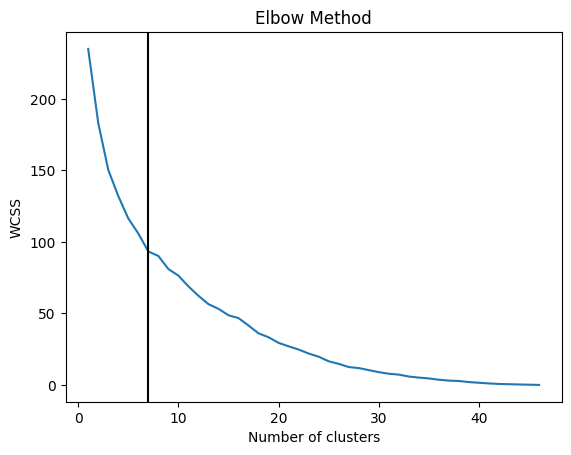

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

df = PINFO_valid
# assuming df is your DataFrame and it only contains numerical columns
# standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# determine the optimal number of clusters
wcss = []
for i in range(1, 47):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 47), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.axvline(x=7, color = 'black')
plt.show()

/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

For n_clusters = 2 The average silhouette_score is: 0.2000790407089849
For n_clusters = 3 The average silhouette_score is: 0.16158099360945166
For n_clusters = 4 The average silhouette_score is: 0.18649977305191287
For n_clusters = 5 The average silhouette_score is: 0.19451358988342263
For n_clusters = 6 The average silhouette_score is: 0.18676530962422744
For n_clusters = 7 The average silhouette_score is: 0.18128174402644093
For n_clusters = 8 The average silhouette_score is: 0.1718645104183466
For n_clusters = 9 The average silhouette_score is: 0.16659555027978307
For n_clusters = 10 The average silhouette_score is: 0.1692061599255603
For n_clusters = 11 The average silhouette_score is: 0.20049265051908707
For n_clusters = 12 The average silhouette_score is: 0.19027711311327253
For n_clusters = 13 The average silhouette_score is: 0.1653906115278345
For n_clusters = 14 The average silhouette_score is: 0.18527862200705086
For n_clusters = 15 The average silhouette_score is: 0.19732851

/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

For n_clusters = 25 The average silhouette_score is: 0.2161425636622852
For n_clusters = 26 The average silhouette_score is: 0.20793340166203633
For n_clusters = 27 The average silhouette_score is: 0.22409347632731264
For n_clusters = 28 The average silhouette_score is: 0.22315977235906106
For n_clusters = 29 The average silhouette_score is: 0.1873328301791561
For n_clusters = 30 The average silhouette_score is: 0.20418139522186018


/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

For n_clusters = 31 The average silhouette_score is: 0.19328927816519526
For n_clusters = 32 The average silhouette_score is: 0.1910329762445283
For n_clusters = 33 The average silhouette_score is: 0.19134339162869657
For n_clusters = 34 The average silhouette_score is: 0.1899096960153124
For n_clusters = 35 The average silhouette_score is: 0.18268637230537943
For n_clusters = 36 The average silhouette_score is: 0.18629795488422285


/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

For n_clusters = 37 The average silhouette_score is: 0.15266936442722343
For n_clusters = 38 The average silhouette_score is: 0.16495891464860934
For n_clusters = 39 The average silhouette_score is: 0.14808102486761032
For n_clusters = 40 The average silhouette_score is: 0.14285922221970665
For n_clusters = 41 The average silhouette_score is: 0.1356157405683722


/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

For n_clusters = 42 The average silhouette_score is: 0.1177380607431934
For n_clusters = 43 The average silhouette_score is: 0.10121478269284713
For n_clusters = 44 The average silhouette_score is: 0.08014847892936433
For n_clusters = 45 The average silhouette_score is: 0.06342950983497567


/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

For n_clusters = 46 The average silhouette_score is: 0.042553190443356696


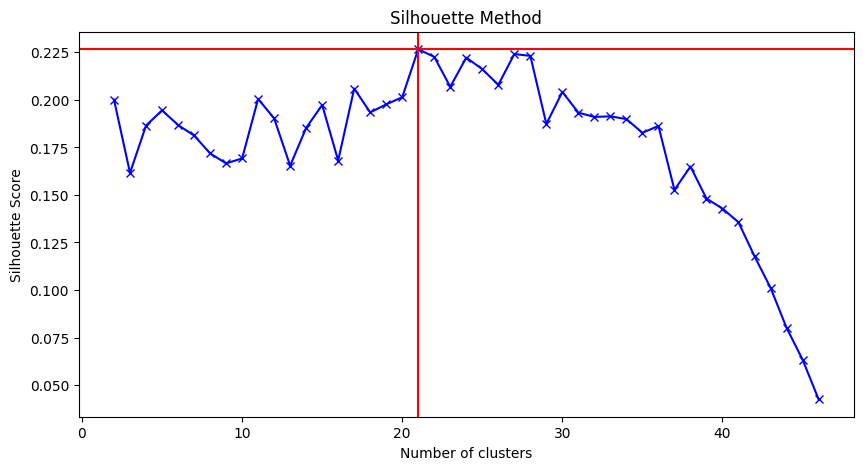

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = [] # holds the silhouette scores for each k
range_n_clusters = list(range(2, 47))

maxi = 0
p_num = 0
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_scaled)
    
    silhouette_avg = silhouette_score(df_scaled, preds)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)
    if silhouette_avg >= maxi:
        maxi = silhouette_avg
        p_num = n_clusters

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.axhline(y=maxi, color='r')
plt.axvline(x=p_num, color='r')
plt.show()


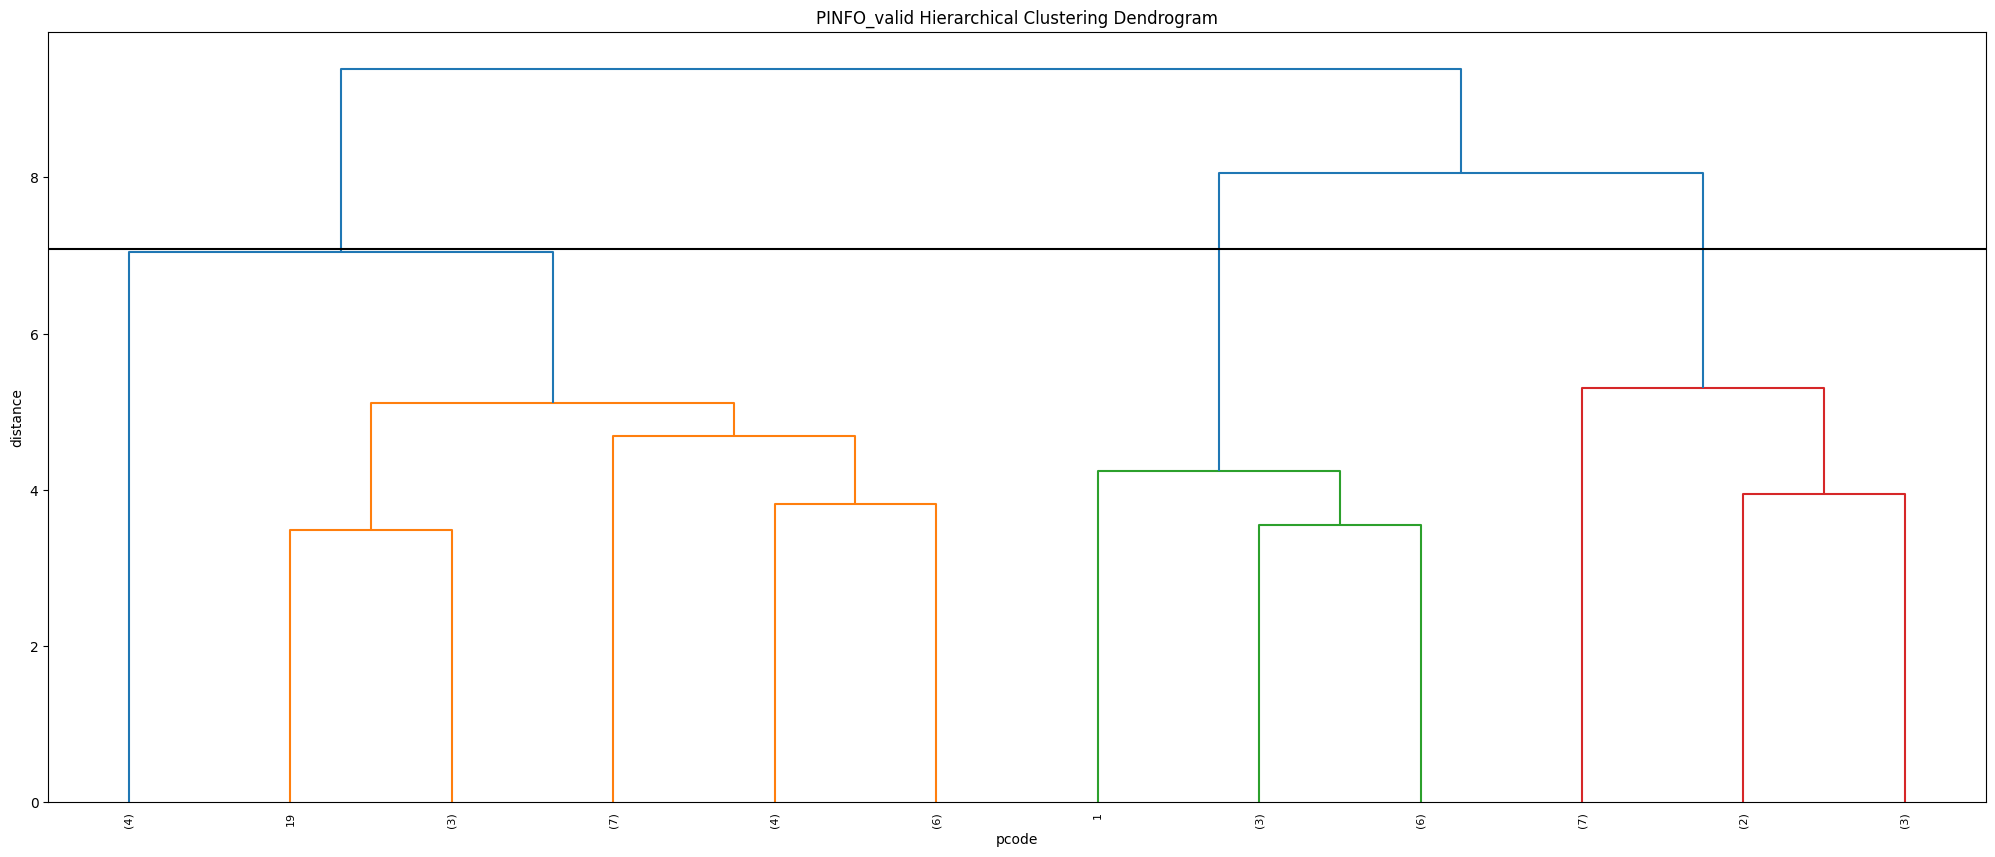

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# generate the linkage matrix
Z = linkage(df_scaled, 'ward')

# set cut-off to 150, max_d as in max_distance
max_d = 7.08                # max_d as in max_distance

plt.figure(figsize=(25, 10))
plt.title('PINFO_valid Hierarchical Clustering Dendrogram')
plt.xlabel('pcode')
plt.ylabel('distance')

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,                   # show only the last p merged clusters
    leaf_rotation=90.,      # rotates the x axis labels
    leaf_font_size=8.,      # font size for the x axis labels
)
plt.axhline(y=max_d, c='k')
plt.show()

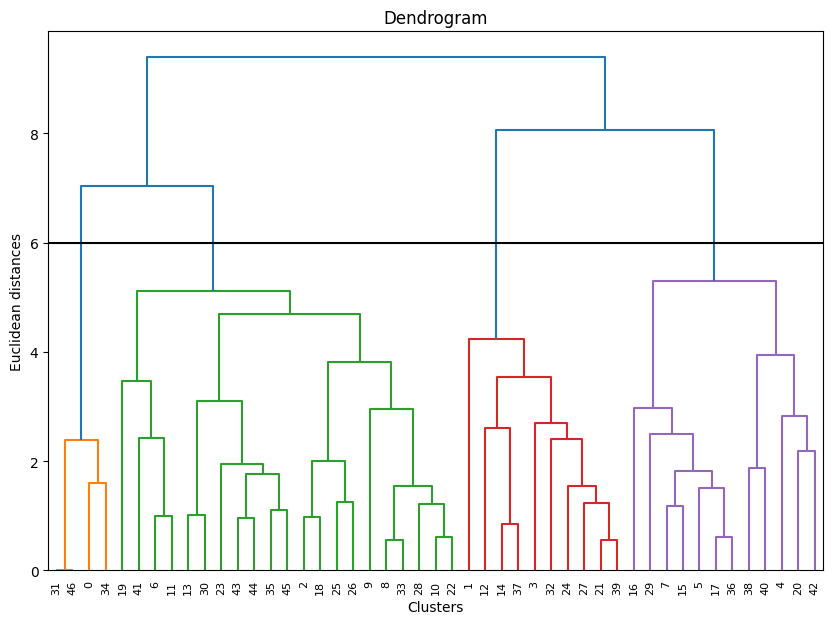

In [101]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(df_scaled, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distances')
plt.axhline(y=6, c='k')
plt.show()


In [65]:
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
import numpy as np

dst = scipy.spatial.distance.euclidean

def gap(data, refs=None, nrefs=20, ks=range(1,11)):
    """
    Compute the Gap statistic for an nxm dataset in data.
    Either give a precomputed set of reference distributions in refs as an (n,m,k) scipy array,
    or state the number k of reference distributions in nrefs for automatic generation with a
    uniformed distribution within the bounding box of data.
    Give the list of k-values for which you want to compute the statistic in ks.
    """
    shape = data.shape
    if refs==None:
        tops = data.max(axis=0)
        bots = data.min(axis=0)
        dists = scipy.matrix(scipy.diag(tops-bots))

        rands = np.random.random_sample(size=(shape[0],shape[1],nrefs))
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+bots
    else:
        rands = refs

    gaps = np.zeros((len(ks),))
    for (i,k) in enumerate(ks):
        (kmc,kml) = scipy.cluster.vq.kmeans2(data, k)
        disp = sum([dst(data[m,:],kmc[kml[m],:]) for m in range(shape[0])])

        refdisps = np.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            (kmc,kml) = scipy.cluster.vq.kmeans2(rands[:,:,j], k)
            refdisps[j] = sum([dst(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])
        gaps[i] = np.log(np.mean(refdisps))-np.log(disp)
    return gaps



/tmp/ipykernel_393639/3935210362.py:20: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  dists = scipy.matrix(scipy.diag(tops-bots))
/home/user/miniconda3/envs/sci-data/lib/python3.9/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


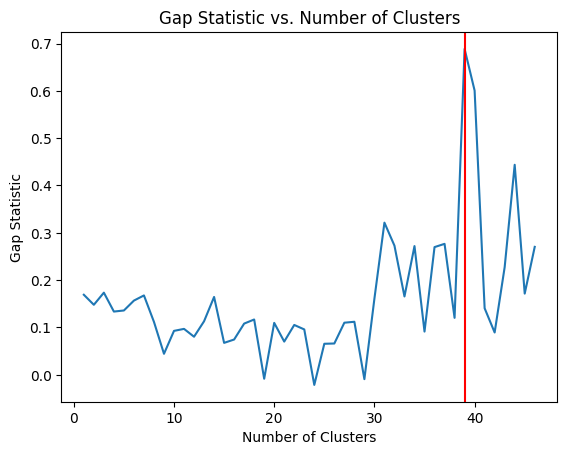

Optimal number of clusters according to Gap statistic: 39


In [104]:
gaps = gap(df_scaled, ks=range(1,47))
plt.plot(range(1,47), gaps)
plt.ylabel("Gap Statistic")
plt.xlabel("Number of Clusters")
plt.title("Gap Statistic vs. Number of Clusters")
plt.axvline(x=np.argmax(gaps) + 1, color='r')
plt.show()
optimal_k = np.argmax(gaps) + 1
print("Optimal number of clusters according to Gap statistic:", optimal_k)


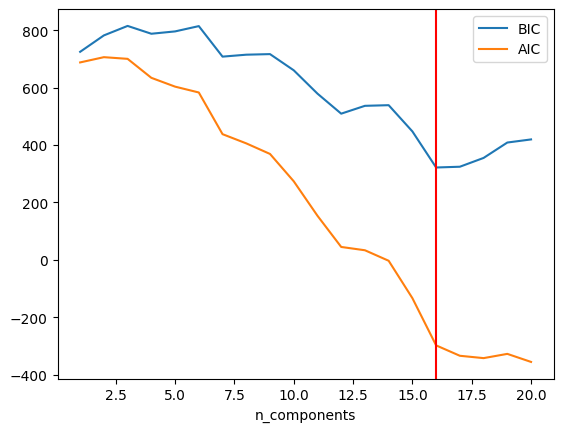

In [105]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df_scaled)
          for n in n_components]

plt.plot(n_components, [m.bic(df_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.axvline(16, color='r')
plt.xlabel('n_components');

# Optimal Number of Clusters via all methods:

<b>Elbow</b>: 7 
<b>Silhoutte Score</b>: 2
<b> Hierarchical Clustering (Dendrogram)</b>: 4
<b>Gap Statistics </b>: 39
<b>AIC and BIC from GMM</b>: 16

Kmeans

In [150]:
#add the optimal numbe rof clusters determined through the above methods
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df_scaled)

In [151]:
pred_y

array([ 7, 11,  0,  2,  5,  6,  8,  6,  0,  0,  0,  8,  3,  4,  3,  6, 10,
        6, 10,  9,  5,  2,  0,  6,  2, 10, 10,  2,  0, 10,  4,  7,  2,  0,
        7,  4,  6,  3,  1,  2,  1,  2,  5,  8,  8,  8,  7], dtype=int32)

In [152]:
df['cluster'] = pred_y

/tmp/ipykernel_809204/264949453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = pred_y


In [153]:
df

,BFI_OPN,BFI_CON,BFI_NEU,BFI_EXT,BFI_AGR,cluster
pcode,,,,,,
P01,11,11,3,4,13,7
P02,14,5,12,14,5,11
P03,10,15,8,7,11,0
P05,10,11,13,10,6,2
P06,3,6,11,3,6,5
P08,10,8,9,9,12,6
P09,12,12,4,11,9,8
P10,6,7,9,9,11,6
P12,9,12,7,7,12,0


In [163]:
count_users_cluster = len(df[df['cluster'] == ])

# Display the count
print("Number of users with cluster value:", count_users_cluster)

Number of users with cluster value: 4


In [123]:
df.to_csv(os.path.join(PATH_INTERMEDIATE,  'similar_user_8.csv'))